# Generate a classification for the parties where they stay within the political spectrum based on Wahlomat data

##### approach:
- append the answer vectors of all elections looked at and cluster
- plausibility check > decide for "final model" to classify based on

In [35]:
# load files

import pickle
file = open("data/election_data_since_2010.obj","rb")
election_df = pickle.load(file)
file.close()

file = open("data/twitter_sample.obj","rb")
twitter_df = pickle.load(file)
file.close()

In [36]:
election_df.head(3)

,party,pct,election,election_only,year,level,date
0,PIRATEN,8.90,Abgeordnetenhauswahl Berlin 2011,Abgeordnetenhauswahl Berlin,2011,federal state,2011-09-18T00:00:00
1,DIE PARTEI,0.88,Abgeordnetenhauswahl Berlin 2011,Abgeordnetenhauswahl Berlin,2011,federal state,2011-09-18T00:00:00
2,ÖDP,0.13,Abgeordnetenhauswahl Berlin 2011,Abgeordnetenhauswahl Berlin,2011,federal state,2011-09-18T00:00:00


In [37]:
twitter_df.head(3)

,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,mentionedUsers,hashtags,cashtags,media,outlinks,retweetedTweet,quotedTweet,inReplyToTweetId,party
0,2022-01-17 11:08:31+00:00,"Manne Weber, auf dem Bild der zweifelsfrei als...","Manne Weber, auf dem Bild der zweifelsfrei als...",1483033488546742272,https://twitter.com/DiePARTEI,6,9,95,1,None,None,None,None,[https://twitter.com/mikeschier/status/1481337...,None,https://twitter.com/mikeschier/status/14813371...,None,DIE PARTEI
1,2022-01-11 11:02:09+00:00,@CSU https://t.co/DAEsinRGKM,@CSU https://t.co/DAEsinRGKM,1480857557287804928,https://twitter.com/DiePARTEI,3,7,346,0,[https://twitter.com/CSU],None,None,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,None,None,None,1480853747840557061,DIE PARTEI
2,2022-01-06 18:21:16+00:00,https://t.co/HjbPmGL396 https://t.co/BIGFBbWSDp,twitter.com/QaharBalkhi/st… https://t.co/BIGFB...,1479156126646247439,https://twitter.com/DiePARTEI,0,10,108,0,None,None,None,[Gif(thumbnailUrl='https://pbs.twimg.com/tweet...,[https://twitter.com/QaharBalkhi/status/147913...,None,https://twitter.com/QaharBalkhi/status/1479135...,None,DIE PARTEI


In [ ]:
# the data needs to be download first from the git hub repro:
# https://github.com/gockelhahn/qual-o-mat-data

In [38]:
## go through all relevant folders (year and import elections within)

import json
import os

years = ["2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021"]
base_path = "qual-o-mat-data-master/data/"

def paths_for_year(y,base_path):
    elections = os.listdir(f"{base_path}{y}/")
    return [base_path+y+"/"+x+"/" for x in elections]

In [39]:
paths = []

for y in years:
    paths.extend(paths_for_year(y,base_path))

In [40]:
wahlomat_data = {} # key: yearstate

# three jsons are important for us: opinion (answer vectors)
# party: to translate party encoding into name
# answer: tocompare answer encoding between elections(same encoding?)
# overview: metadata

def import_jsons(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)
    

# load the differen data for each election into a dict where the key is the election name
for p in paths:
    opinion = import_jsons(f"{p}opinion.json")
    party = import_jsons(f"{p}party.json")
    answer = import_jsons(f"{p}answer.json")
    overview = import_jsons(f"{p}overview.json")
    title = overview["title"]
    date = overview["date"] #yyy-mm-dd
    
    wahlomat_data[f"{title} {date[:4]}"] = {"overview":overview,
                                            "opinion":opinion,
                                            "answer":answer,
                                            "party":party}
    

In [41]:

def party_dict_gen(party_json):
    '''
    input: jsons for one election
    out: dict to translate from party id to party name
    '''
    
    out = {}
    
    for i in party_json:
        out[i["id"]] = i["name"]
        
    return out

def opinion_dict(opinion):
    '''
    input: opinion jason for election
    out: dict containing party id as key and answer vector as item
    '''
    o_dict = {} #each parties digit code will be key and the value a list of its answers to the statements

    for o in opinion:
        party_ = o["party"]
        if party_ in o_dict.keys():
            o_dict[party_].append(o["answer"])
        else:
            o_dict[party_] = [o["answer"]]
    return o_dict

In [42]:
def encode_party(opinion_dict, party_dict):
    '''
    changes key of opinion dict from id to party name
    '''
    new_opinion_dict= {}
    
    for k,v in opinion_dict.items():
        new_opinion_dict[party_dict[k]] = v
    return new_opinion_dict
    

In [43]:
rows = []

# go through each election in the wahlomat dict
for election,item in wahlomat_data.items():
    n = item["overview"]["title"] # get election title
    d = item["overview"]["date"] # get election date
    o = opinion_dict(item["opinion"]) # get opinion dict for election where key=party id and item=answer vector
    p_dict = party_dict_gen(item["party"]) #id to party dict for respective election
    
    
    ##adjust opinion dict party names
    o = encode_party(o,p_dict)
    
    # append read out data to rows list
    rows.append({"election":election,"name":n,"date":d,"opinions":o})
    
import pandas as pd

# generate dataframe from loaded data
wahlomat_df = pd.DataFrame(rows)

### do the clustering for all parties that participated in state and europe elections since 2011
### use the outcome to classify the party sample, republikaner get classified manually/ based on a subclustering based on its elections

# 1. filter wahlomat_ds for relevant elections

cluster_df = wahlomat_df[(wahlomat_df["name"] == "Bundestagswahl") | (wahlomat_df["name"] == "Europawahl")]

# 2. adjust union/cdu csu
## one election they are seperated, add to the other 4 one init for each of them (with same values)

cluster_df.loc[9,"opinions"]["CDU"] = cluster_df.loc[9,"opinions"]['CDU / CSU']
cluster_df.loc[9,"opinions"]["CSU"] = cluster_df.loc[9,"opinions"]['CDU / CSU']

cluster_df.loc[21,"opinions"]["CDU"] = cluster_df.loc[21,"opinions"]['CDU/CSU']
cluster_df.loc[21,"opinions"]["CSU"] = cluster_df.loc[21,"opinions"]['CDU/CSU']

cluster_df.loc[29,"opinions"]["CDU"] = cluster_df.loc[29,"opinions"]['CDU / CSU']
cluster_df.loc[29,"opinions"]["CSU"] = cluster_df.loc[29,"opinions"]['CDU / CSU']

cluster_df.loc[35,"opinions"]["CSU"] = cluster_df.loc[35,"opinions"]['CDU / CSU']
cluster_df.loc[35,"opinions"]["CDU"] = cluster_df.loc[35,"opinions"]['CDU / CSU']

# delete csu/cdu entries
cluster_df.loc[9,"opinions"].pop("CDU / CSU")
cluster_df.loc[21,"opinions"].pop("CDU/CSU")
cluster_df.loc[29,"opinions"].pop("CDU / CSU")
cluster_df.loc[35,"opinions"].pop("CDU / CSU")

cluster_df.head(3)

,election,name,date,opinions
9,Bundestagswahl 2013,Bundestagswahl,2013-09-22,"{'SPD': [0, 1, 1, 0, 0, 2, 1, 2, 0, 0, 1, 1, 1..."
12,Europawahl 2014,Europawahl,2014-05-25,"{'CDU': [0, 1, 2, 1, 1, 2, 1, 1, 2, 0, 0, 1, 1..."
21,Bundestagswahl 2017,Bundestagswahl,2017-09-24,"{'SPD': [1, 1, 1, 0, 0, 2, 0, 2, 1, 2, 0, 1, 1..."


In [44]:

# 3. check names here and align to filter for parties participating in all 5 elections
parties_wahlomat = []

for op in cluster_df.opinions:
    parties = op.keys()
    parties_wahlomat.extend(parties)
    
print(set(parties_wahlomat))

{'Bündnis C', 'Partei der Nichtwähler', 'LfK', 'GRÜNE', 'Volksabstimmung', 'Allianz Deutscher Demokraten', 'V-Partei³', 'DIE RECHTE', 'du.', 'Team Todenhöfer', 'PARTEI DER VERNUNFT', 'Bündnis 21/RRP', 'BüSo', 'PDV', 'NPD', 'III. Weg', 'Graue Panther', 'BP', 'LKR', 'PRO NRW', 'BÜNDNIS21', 'CM', 'Tierschutzallianz', 'UNABHÄNGIGE', 'BGE', 'BÜRGERBEWEGUNG', 'CDU', 'PdF', 'FDP', 'FAMILIE', 'MENSCHLICHE WELT', 'LIEBE', 'NL', 'DiB', 'PARTEI FÜR DIE TIERE', 'DKP', 'B*', 'REP', 'Gesundheitsforschung', 'ÖkoLinX', 'SGP', 'Die PARTEI', 'RENTNER', 'DIE LINKE', 'MLPD', 'ÖDP', 'TIERSCHUTZ hier!', 'CSU', 'DIE DIREKTE!', 'AUF', 'PBC', 'FREIE WÄHLER', 'PSG', 'DM', 'PIRATEN', 'SPD', 'Die Humanisten', 'Tierschutzpartei', 'DIE FRAUEN', 'Die Grauen', 'DIE VIOLETTEN', 'DiEM25', 'dieBasis', 'BIG', 'Volt', 'AfD', 'SSW', 'pro Deutschland'}


In [45]:
# to correct

cluster_df.reset_index(drop=True,inplace=True)
cluster_df.loc[0,"opinions"]["BÜNDNIS21"] = cluster_df.loc[0,"opinions"].pop('Bündnis 21/RRP')


In [46]:
cluster_df

,election,name,date,opinions
0,Bundestagswahl 2013,Bundestagswahl,2013-09-22,"{'SPD': [0, 1, 1, 0, 0, 2, 1, 2, 0, 0, 1, 1, 1..."
1,Europawahl 2014,Europawahl,2014-05-25,"{'CDU': [0, 1, 2, 1, 1, 2, 1, 1, 2, 0, 0, 1, 1..."
2,Bundestagswahl 2017,Bundestagswahl,2017-09-24,"{'SPD': [1, 1, 1, 0, 0, 2, 0, 2, 1, 2, 0, 1, 1..."
3,Europawahl 2019,Europawahl,2019-05-26,"{'SPD': [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0..."
4,Bundestagswahl 2021,Bundestagswahl,2021-09-26,"{'SPD': [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1..."


In [47]:
parties_wahlomat = []

for op in cluster_df.opinions:
    parties = op.keys()
    parties_wahlomat.extend(parties)
    
print(set(parties_wahlomat))

{'Bündnis C', 'Partei der Nichtwähler', 'LfK', 'GRÜNE', 'Volksabstimmung', 'Allianz Deutscher Demokraten', 'V-Partei³', 'DIE RECHTE', 'du.', 'Team Todenhöfer', 'PARTEI DER VERNUNFT', 'Graue Panther', 'BüSo', 'BÜNDNIS21', 'NPD', 'PDV', 'III. Weg', 'BP', 'LKR', 'PRO NRW', 'CM', 'Tierschutzallianz', 'UNABHÄNGIGE', 'BGE', 'BÜRGERBEWEGUNG', 'CDU', 'PdF', 'FDP', 'FAMILIE', 'MENSCHLICHE WELT', 'LIEBE', 'NL', 'DiB', 'PARTEI FÜR DIE TIERE', 'DKP', 'B*', 'REP', 'Gesundheitsforschung', 'ÖkoLinX', 'SGP', 'Die PARTEI', 'RENTNER', 'DIE LINKE', 'MLPD', 'ÖDP', 'TIERSCHUTZ hier!', 'CSU', 'DIE DIREKTE!', 'AUF', 'PBC', 'FREIE WÄHLER', 'PSG', 'DM', 'PIRATEN', 'SPD', 'Die Humanisten', 'Tierschutzpartei', 'DIE FRAUEN', 'Die Grauen', 'DIE VIOLETTEN', 'DiEM25', 'dieBasis', 'BIG', 'Volt', 'AfD', 'SSW', 'pro Deutschland'}


In [48]:
# chech for parties that run for all 5 election

parties_sets = []

for i in cluster_df["opinions"]:
    
    # add sets for each election to list
    parties_sets.append(set(i.keys()))
    
# get intersection between these sets
print(set.intersection(*parties_sets))

{'CDU', 'CSU', 'FDP', 'SPD', 'GRÜNE', 'Tierschutzpartei', 'FREIE WÄHLER', 'NPD', 'Die PARTEI', 'BP', 'DIE LINKE', 'PIRATEN', 'AfD', 'MLPD', 'ÖDP'}


In [49]:
election_df.party.unique()

array(['PIRATEN', 'DIE PARTEI', 'ÖDP', 'REP', 'BP'], dtype=object)

#### comments
- Pirates, die partei, ödp and bp participated in all 5 elections
- for republicans a seperate clustering will be conducted

In [50]:
cluster_sample_parties = list(set.intersection(*parties_sets))
opinion_total = dict.fromkeys(cluster_sample_parties, [])

# concatenate the answer vectors for the 5 election for each party except Republikaner
for key in cluster_sample_parties:
    new_vec = []
    for cell in cluster_df["opinions"]:
        new_vec.extend(cell[key])
    opinion_total[key] = new_vec

# Try two different clusterings for robustness

- KModes
- Agglomerative CLustering

#### custering Kmodes

In [51]:
import numpy as np
from kmodes.kmodes import KModes

data = np.array(list(opinion_total.values()))

In [52]:
data

array([[1, 0, 1, ..., 2, 1, 0],
       [1, 0, 1, ..., 2, 1, 0],
       [1, 2, 1, ..., 1, 1, 2],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [53]:
km = KModes(n_clusters=2, init='Huang', n_init=10, verbose=1)

clusters = km.fit_predict(data)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1, cost: 732.0
Run 1, iteration: 2/100, moves: 0, cost: 732.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1, cost: 732.0
Run 2, iteration: 2/100, moves: 0, cost: 732.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 732.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1, cost: 732.0
Run 4, iteration: 2/100, moves: 0, cost: 732.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2, cost: 732.0
Run 5, iteration: 2/100, moves: 0, cost: 732.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 1, cost: 732.0
Run 6, iteration: 2/100, moves: 0, cost: 732.0
Ini

In [54]:
# get clustering
cluster = {}

for i,e in enumerate(km.labels_):
    if e not in cluster.keys():
        cluster[e] = [party[i]["id"]]
    else:
        cluster[e].append(party[i]["id"])
        
cluster = dict(sorted(cluster.items()))
cluster

{0: [3, 4, 5, 8, 10, 11, 13, 14], 1: [0, 1, 2, 6, 7, 9, 12]}

In [55]:
# translate dict for ids from clustering
cl_p_dict = dict.fromkeys(range(0,15))
for i,p in enumerate(opinion_total.keys()):
    cl_p_dict[i] = p

In [56]:
cl_p_dict

{0: 'CDU',
 1: 'CSU',
 2: 'FDP',
 3: 'SPD',
 4: 'GRÜNE',
 5: 'Tierschutzpartei',
 6: 'FREIE WÄHLER',
 7: 'NPD',
 8: 'Die PARTEI',
 9: 'BP',
 10: 'DIE LINKE',
 11: 'PIRATEN',
 12: 'AfD',
 13: 'MLPD',
 14: 'ÖDP'}

In [57]:
# print cluster
for c,ps in cluster.items():
    print(f"Cluster: {c}")
    for p in ps:
        print(cl_p_dict[p])

Cluster: 0
SPD
GRÜNE
Tierschutzpartei
Die PARTEI
DIE LINKE
PIRATEN
MLPD
ÖDP
Cluster: 1
CDU
CSU
FDP
FREIE WÄHLER
NPD
BP
AfD


In [58]:
# bi-polar clustering left/right leaning fitting common conception

#### hirarchical clustering




In [59]:
import sklearn
from sklearn.cluster import AgglomerativeClustering as AG

In [60]:
clustering = AG().fit(data)

In [61]:
clustering.labels_

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int64)

In [62]:
wahlomat_data["Bundestagswahl 2013"]["answer"]

[{'id': 0, 'message': 'Stimme zu'},
 {'id': 1, 'message': 'Stimme nicht zu'},
 {'id': 2, 'message': 'Neutral'}]

In [63]:
### what is needed:

# transform data to ordinal logic:
# switch 1 and 2
## > stimm zu > neutral > stimme nicht zu

data[data==1] = 5 # placeholder

data[data==2] = 1

data[data==5] = 2

In [64]:
data

array([[2, 0, 2, ..., 1, 2, 0],
       [2, 0, 2, ..., 1, 2, 0],
       [2, 1, 2, ..., 2, 2, 1],
       ...,
       [2, 2, 2, ..., 2, 2, 0],
       [0, 2, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 2]])

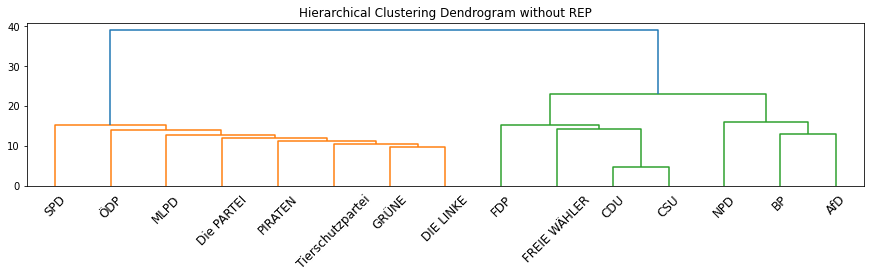

In [65]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs, labels=list(cl_p_dict.values()))


X = data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)


plt.figure(figsize=(15,3))
plt.title("Hierarchical Clustering Dendrogram without REP")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=14)
plt.xticks(rotation=45)
plt.savefig("plots/dendo_classification.png",bbox_inches='tight')

plt.show()

In [66]:
# generate dummy variables for political_leaning (0=right,1=left)

clustering.labels_

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int64)

In [67]:
opinion_total.keys()
# Die PARTEI > DIE 

dict_keys(['CDU', 'CSU', 'FDP', 'SPD', 'GRÜNE', 'Tierschutzpartei', 'FREIE WÄHLER', 'NPD', 'Die PARTEI', 'BP', 'DIE LINKE', 'PIRATEN', 'AfD', 'MLPD', 'ÖDP'])

In [68]:
leaning_dict = {k.upper():v for k,v in zip(opinion_total.keys(),clustering.labels_)}
leaning_dict["LINKE"] = leaning_dict.pop("DIE LINKE")
leaning_dict["REP"] = 0 #manually added do proof !!!!

In [69]:
election_df["leaning"] = [leaning_dict[party] for party in election_df["party"]]

In [70]:
leaning_dict

{'CDU': 0,
 'CSU': 0,
 'FDP': 0,
 'SPD': 1,
 'GRÜNE': 1,
 'TIERSCHUTZPARTEI': 1,
 'FREIE WÄHLER': 0,
 'NPD': 0,
 'DIE PARTEI': 1,
 'BP': 0,
 'PIRATEN': 1,
 'AFD': 0,
 'MLPD': 1,
 'ÖDP': 1,
 'LINKE': 1,
 'REP': 0}

In [71]:
election_df.head()

,party,pct,election,election_only,year,level,date,leaning
0,PIRATEN,8.90,Abgeordnetenhauswahl Berlin 2011,Abgeordnetenhauswahl Berlin,2011,federal state,2011-09-18T00:00:00,1
1,DIE PARTEI,0.88,Abgeordnetenhauswahl Berlin 2011,Abgeordnetenhauswahl Berlin,2011,federal state,2011-09-18T00:00:00,1
2,ÖDP,0.13,Abgeordnetenhauswahl Berlin 2011,Abgeordnetenhauswahl Berlin,2011,federal state,2011-09-18T00:00:00,1
3,DIE PARTEI,1.95,Abgeordnetenhauswahl Berlin 2016,Abgeordnetenhauswahl Berlin,2016,federal state,2016-09-18T00:00:00,1
4,PIRATEN,1.73,Abgeordnetenhauswahl Berlin 2016,Abgeordnetenhauswahl Berlin,2016,federal state,2016-09-18T00:00:00,1


In [72]:
import pickle
file = open("data/election_leaning.obj","wb")
pickle.dump(election_df,file)
file.close()

# Proof for classification of Republikaner

In [73]:
# check in which subset REP participated

for i,d in enumerate(cluster_df["opinions"]):
    if "REP" in d.keys():
        print(i)

0
1


In [74]:
# first two rows, repeat clustering with that subset

cluster_df_rep = cluster_df.iloc[:2,:]

In [75]:
cluster_df_rep

,election,name,date,opinions
0,Bundestagswahl 2013,Bundestagswahl,2013-09-22,"{'SPD': [0, 1, 1, 0, 0, 2, 1, 2, 0, 0, 1, 1, 1..."
1,Europawahl 2014,Europawahl,2014-05-25,"{'CDU': [0, 1, 2, 1, 1, 2, 1, 1, 2, 0, 0, 1, 1..."


In [76]:
parties_sets = []

for i in cluster_df_rep["opinions"]:
    parties_sets.append(set(i.keys()))
    

In [77]:
cluster_sample_parties = list(set.intersection(*parties_sets))
opinion_total = dict.fromkeys(cluster_sample_parties, [])

for key in cluster_sample_parties:
    print(key)
    new_vec = []
    for cell in cluster_df_rep["opinions"]:
        new_vec.extend(cell[key])
    opinion_total[key] = new_vec

Volksabstimmung
GRÜNE
BüSo
NPD
BP
CDU
FDP
FAMILIE
REP
Die PARTEI
DIE LINKE
MLPD
ÖDP
CSU
PBC
FREIE WÄHLER
PSG
PIRATEN
SPD
Tierschutzpartei
AfD


In [78]:
data = np.array(list(opinion_total.values()))

data[data==1] = 5 # placeholder

data[data==2] = 1

data[data==5] = 2

In [79]:
len(clustering.labels_)

15

In [80]:
cl_p_dict = dict.fromkeys(range(0,21))
for i,p in enumerate(opinion_total.keys()):
    cl_p_dict[i] = p

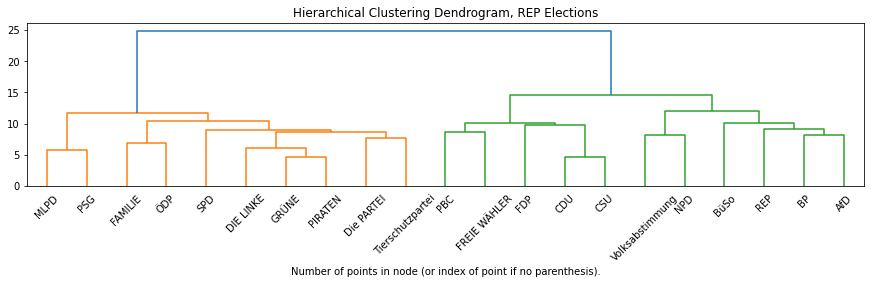

In [81]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs, labels=list(cl_p_dict.values()))


X = data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)


plt.figure(figsize=(15,3))
plt.title("Hierarchical Clustering Dendrogram, REP Elections")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=14)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.xticks(rotation=45)
plt.savefig("plots/dendo_classification_rep.png",bbox_inches='tight')
plt.show()